In [1]:
import os
import shutil
import sys
import cv2
import torch
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
import matplotlib.pyplot as plt

sys.path.append("./rl_evaluation/PerceptualSimilarity-1.0/")
import models
from util import util

import lpips
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
loss_fn_vgg = lpips.LPIPS(net='vgg')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/yiheng/anaconda3/envs/pytorch/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/yiheng/anaconda3/envs/pytorch/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


In [1]:


def evaluate_images(kitti_gt_path, paired_path):
    # selected image indices
    select_index = np.arange(1, 160)
    select_images = ["000%3s.png" % i for i in select_index]

    lpips_model = models.PerceptualLoss(use_gpu=torch.cuda.is_available())

    psnr_value_list = []
    lpips_value_list = []
    ssim_value_list = []
    for _select_image in select_images:
        gt_image_path = os.path.join(kitti_gt_path, _select_image[-10:])
        original_image_path = os.path.join(paired_path, _select_image)

        original_img = cv2.imread(original_image_path)
        gt_img = cv2.imread(gt_image_path)

        psnr = compare_psnr(gt_img, original_img)
        ssim = compare_ssim(gt_img, original_img, channel_axis=2, data_range=255)

        gt_tensor = util.im2tensor(gt_img)
        original_tensor = util.im2tensor(original_img)
        lpips = torch.square(lpips_model.forward(gt_tensor, original_tensor))
        lpips_tmp = lpips.detach().numpy()[0][0][0][0]

        psnr_value_list.append(psnr)
        ssim_value_list.append(ssim)
        lpips_value_list.append(lpips_tmp)

    avg_psnr = np.array(psnr_value_list).mean()
    avg_ssim = np.array(ssim_value_list).mean()
    avg_lpips = np.array(lpips_value_list).mean()

    print("psnr=%.5f ssim=%.5f lpips=%.5f" % (avg_psnr, avg_ssim, avg_lpips))
    print(np.array(psnr_value_list).max(), np.array(ssim_value_list).max(), np.array(lpips_value_list).min())
    print(psnr_value_list)
    print(ssim_value_list)
    print(lpips_value_list)


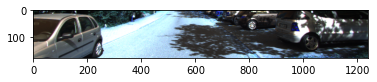

In [36]:
plt.imshow(gt_img[200:])

In [9]:
torch.tensor(gt_img)

tensor([[219, 235, 243,  ...,  11,  14,  14],
        [210, 218, 232,  ...,   8,   8,   8],
        [121, 137, 171,  ...,   5,   6,   8],
        ...,
        [ 45,  49,  56,  ...,  28,  31,  33],
        [ 61,  66,  68,  ...,  26,  30,  32],
        [ 69,  67,  67,  ...,  27,  28,  31]], dtype=torch.uint8)

In [10]:
kitti_gt_path = "/home/yiheng/dataset/kitti-02/image_2"
paired_path = "/home/yiheng/dataset/kitti-02/image_filled"

# selected image indices
select_index = np.arange(369, 575)
select_images = ["%06d.png" % i for i in select_index] 

# lpips_model = models.PerceptualLoss(use_gpu=torch.cuda.is_available())

psnr_value_list = []
lpips_value_list = []
ssim_value_list = []
for _select_image in select_images:
    gt_image_path = os.path.join(kitti_gt_path, _select_image[-10:])
    original_image_path = os.path.join(paired_path, _select_image)

    original_img = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
    gt_img = cv2.imread(gt_image_path, cv2.IMREAD_GRAYSCALE)

    psnr = compare_psnr(gt_img, original_img)
    # ssim = compare_ssim(gt_img, original_img, channel_axis=2, data_range=255)
    ssim = compare_ssim(gt_img, original_img, channel_axis=1)

    # gt_tensor = util.im2tensor(gt_img)
    # original_tensor = util.im2tensor(original_img)
    gt_tensor = torch.tensor(gt_img)
    original_tensor = torch.tensor(original_img)
    lpips = loss_fn_alex(gt_tensor, original_tensor)
    lpips_tmp = lpips.detach().numpy()[0][0][0][0]

    psnr_value_list.append(psnr)
    ssim_value_list.append(ssim)
    lpips_value_list.append(lpips_tmp)

avg_psnr = np.array(psnr_value_list).mean()
avg_ssim = np.array(ssim_value_list).mean()
avg_lpips = np.array(lpips_value_list).mean()

print("psnr=%.5f ssim=%.5f lpips=%.5f" % (avg_psnr, avg_ssim, avg_lpips))
print(np.array(psnr_value_list).max(), np.array(ssim_value_list).max(), np.array(lpips_value_list).min())
# print(psnr_value_list)
# print(ssim_value_list)
# print(lpips_value_list)

psnr=13.87846 ssim=0.44629 lpips=0.19164
15.861258562115367 0.5718092113145613 0.12763263


kitti-02
paired psnr=12.31825 ssim=0.38453 lpips=0.46338
15.84546805603809 0.5045253659750183 0.3987272

gan psnr=14.51296 ssim=0.41083 lpips=0.35449
18.170917209405392 0.5613538958202912 0.29123986

filled psnr=14.43560 ssim=0.43578 lpips=0.38539
17.23800960729114 0.5463096652713028 0.3235725



# 图像修复

In [4]:
import os
from PIL import Image

def resize_images(src_folder, dst_folder, new_size=(1241, 376)):
# def resize_images(src_folder, dst_folder, new_size=(618, 185)):
    if not os.path.exists(dst_folder):
        os.makedirs(dst_folder)
    for filename in os.listdir(src_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # 检查文件是否为图像文件
            img_path = os.path.join(src_folder, filename)
            img = Image.open(img_path)
            img = img.resize(new_size, Image.ANTIALIAS)  # 调整图像大小
            new_img_path = os.path.join(dst_folder, filename)
            img.save(new_img_path)  # 保存新图像



In [7]:
src_folder = '/home/yiheng/dataset/kitti-02/synthesized_image/'  # 原始图像的文件夹路径
dst_folder = '/home/yiheng/dataset/kitti-02/synthesized_image_resized/'  # 新的文件夹路径
resize_images(src_folder, dst_folder)

In [26]:
import os
from PIL import Image
import numpy as np

# 源文件夹路径和目标文件夹路径
src_folder1 = '/home/yiheng/dataset/kitti-02/paired'  # 请替换为实际路径
src_folder2 = '/home/yiheng/dataset/kitti-02/synthesized_image_resized'  # 请替换为实际路径
src_folder3 = '/home/yiheng/dataset/kitti-02/semantics'  # 请替换为实际路径
dst_folder = '/home/yiheng/dataset/kitti-02/image_filled'  # 请替换为实际路径

# 如果目标文件夹不存在，创建它
if not os.path.exists(dst_folder):
    os.makedirs(dst_folder)

# 遍历文件夹
for i in range(369, 576):  
    filename1 = f"{src_folder1}/{i:06d}.png"  # 构建第一个文件夹的文件名
    filename2 = f"{src_folder2}/{i:06d}.png"  # 构建第二个文件夹的文件名
    filename3 = f"{src_folder3}/{i:06d}.png"  # 构建语义分割结果文件名
    
    img1 = Image.open(filename1)
    img2 = Image.open(filename2)
    img3 = Image.open(filename3)
    
    img1_np = np.array(img1)
    img2_np = np.array(img2)
    img3_np = np.array(img3)
    
    # 找到黑色像素
    black_pixels = (img1_np == [0, 0, 0]).all(axis=-1)
    
    # 1. 替换所有
    img1_np[black_pixels] = img2_np[black_pixels]
    
    
    # 2. 替换指定区域
    # # 找到label等于0，1，9的像素[0, 1, 2, 8, 9, 14]
    # replace_labels = np.isin(img3_np, np.arange(0, 20))
    # replace_pixels = np.logical_and(black_pixels, replace_labels)
    # img1_np[replace_pixels] = img2_np[replace_pixels]
    
    new_img = Image.fromarray(img1_np)
    new_img.save(f"{dst_folder}/{i:06d}.png")
        # 找到黑色像素和label不等于10的像素
    # black_pixels = (img1_np == [0, 0, 0]).all(axis=-1)
    # not_sky_pixels = img3_np != 10
    
    # # 只有在像素是黑色并且label不等于10的情况下才进行替换
    # replace_pixels = np.logical_and(black_pixels, not_sky_pixels)
    
    # img1_np[replace_pixels] = img2_np[replace_pixels]
    
    # new_img = Image.fromarray(img1_np)
    # new_img.save(f"{dst_folder}/{i:06d}.png")

In [36]:
img1_np.shape

(376, 1241, 3)

In [37]:
img2_np.shape

(376, 1241, 3)

In [38]:
img3_np.shape

(376, 1241)